In [ ]:
import numpy as np
import pickle
from scipy.special import gamma
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [ ]:
# Parameters
C = 1
G = 25
M = 26
Y = 1.5
S0 = 40
numPaths = 1000
timepoints= 50
T = 1
r = 0.05
A = (G - M) / 2
B = (G + M) / 2
w = C * gamma(-Y) * ((M - 1)**Y - M**Y + (G + 1)**Y - G**Y)
epsilon = 1E-4
d = (epsilon**(1 - Y / 2)) / (1 - Y / 2)
_lambda = 2 / (epsilon**(Y / 2) * Y)
pathSize = int(np.ceil(_lambda * (T) + 1))

In [ ]:
# Functions
def CGMYSubLaplace(y, Y, B):
    return (np.exp((-B**2 * y) / 2) * gamma((Y + 1) / 2) * 2**Y * (B**2 * y / 2)**(Y / 2) * I(Y, B**2 * y, B**2 * y / 2)) / (gamma(Y) * np.sqrt(np.pi))

def ParCyl(p, z):
    S = 1
    c = 1
    g = gamma(-p / 2 + 0.5)
    H = gamma(-p / 2)

    if np.all(z < 40):
        u = Hypergeometric(-p / 2, 0.5, z * z / 2)
        v = Hypergeometric(0.5 - p / 2, 1.5, z * z / 2)
        D = 2**(p / 2) * np.exp(-z * z / 4) * ((np.sqrt(np.pi) * u / g) - np.sqrt(2 * np.pi) * z * v / H)
    else:
        for i in range(1, 21):
            c = c * -(p - i + 1) * (p - i) / (2 * i * z**(2 * i))
            S = S + c
        D = np.exp(-z**2 / 4) * z**p * S

    return D

def Hypergeometric(a, b, z):
    ret = 1
    term = np.ones_like(z)
    n = 1
    while np.max(term) > 1E-4 and n < 100:
        term = term * ((a + n - 1) * z / (n * (b + n - 1)))
        ret = ret + term
        n += 1
    return ret

def I(Y, a, _lambda):
    return (2 * _lambda)**(-Y / 2) * gamma(Y) * np.exp(a**2 / (8 * _lambda)) * ParCyl(-Y, (a / np.sqrt(2 * _lambda)))

In [ ]:
# Simulation
temValue = np.zeros((numPaths, timepoints))
# Initialize an empty list to store St values
St_list = []
for i in range(numPaths):
    # Vector of jump times
    tj = [0]
    while tj[-1] < T:
        U2 = np.random.rand(pathSize)
        ti = -np.log(1 - U2) / _lambda
        tj.extend(tj[-1] + np.cumsum(ti))

    tj = np.array(tj)
    tj = tj[tj < T]

    # Vector of jump magnitudes
    U1 = np.random.rand(len(tj) - 1)
    yj = np.concatenate(([0], epsilon / (1 - U1)**(2 / Y)))
    # CGMY subordinator (Rosinski)
    U3 = np.random.rand(len(yj))
    Ht = d * tj + np.cumsum(yj * (CGMYSubLaplace(yj, Y, B) > U3))

    # CGMY random variable
    X = A * Ht + np.sqrt(Ht) * np.random.randn(len(Ht))
    St = S0 * np.exp((r - w) * tj + X)
    # Interpolation
    interp_func = interp1d(tj, St, bounds_error=False, fill_value="extrapolate")
    interp_values = np.array([interp_func(k / timepoints) for k in range(1, timepoints)])
    temValue[i, :] = np.concatenate((interp_values, [St[-1]]))

# Remove paths with maximum beyond XXX
temValue = temValue[np.max(temValue, axis=1) <400, :]

# Remove paths with negative values
positive_paths_mask = np.all(temValue >= 0, axis=1)
temValue = temValue[positive_paths_mask, :]
temValue = temValue[:, :-1]

first_column = np.full((temValue.shape[0], 1), S0)

# Add the new first column to temValue
temValue = np.hstack((first_column, temValue))


meanValue = np.mean(temValue, axis=0)


<ipython-input-99-5d864923aeb9>:34: RuntimeWarning: divide by zero encountered in power
  return (2 * _lambda)**(-Y / 2) * gamma(Y) * np.exp(a**2 / (8 * _lambda)) * ParCyl(-Y, (a / np.sqrt(2 * _lambda)))
<ipython-input-99-5d864923aeb9>:34: RuntimeWarning: invalid value encountered in true_divide
  return (2 * _lambda)**(-Y / 2) * gamma(Y) * np.exp(a**2 / (8 * _lambda)) * ParCyl(-Y, (a / np.sqrt(2 * _lambda)))
<ipython-input-99-5d864923aeb9>:34: RuntimeWarning: overflow encountered in exp
  return (2 * _lambda)**(-Y / 2) * gamma(Y) * np.exp(a**2 / (8 * _lambda)) * ParCyl(-Y, (a / np.sqrt(2 * _lambda)))
<ipython-input-99-5d864923aeb9>:34: RuntimeWarning: invalid value encountered in multiply
  return (2 * _lambda)**(-Y / 2) * gamma(Y) * np.exp(a**2 / (8 * _lambda)) * ParCyl(-Y, (a / np.sqrt(2 * _lambda)))
<ipython-input-99-5d864923aeb9>:3: RuntimeWarning: invalid value encountered in multiply
  return (np.exp((-B**2 * y) / 2) * gamma((Y + 1) / 2) * 2**Y * (B**2 * y / 2)**(Y / 2) * I(Y, B

In [ ]:
print(temValue)

[[ 40.          40.47833549  39.67990132 ...  10.55749898  79.20431862
   20.10280886]
 [ 40.          33.69192392  43.27425733 ...  27.67316004  19.55677035
   40.4272744 ]
 [ 40.          38.41427707  43.78303377 ...  43.99954653  34.27907532
   78.48583393]
 ...
 [ 40.          39.23437336  44.7504277  ...   7.37487543  30.12466322
   55.00315647]
 [ 40.          42.9880962   39.56695911 ...  66.82541788 104.66456855
    6.86535052]
 [ 40.          46.41330784  49.85912077 ...  18.84841248  40.77269574
  125.12960484]]


In [ ]:
print(temValue.shape)

(992, 50)


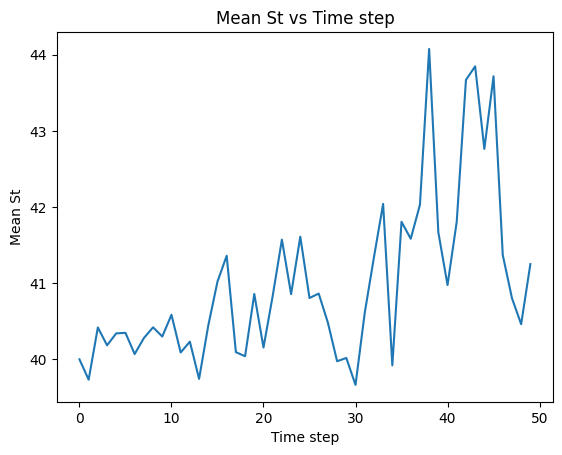

In [ ]:
# Plot the mean St values
plt.plot(meanValue)
plt.xlabel('Time step')
plt.ylabel('Mean St')
plt.title('Mean St vs Time step')
plt.show()

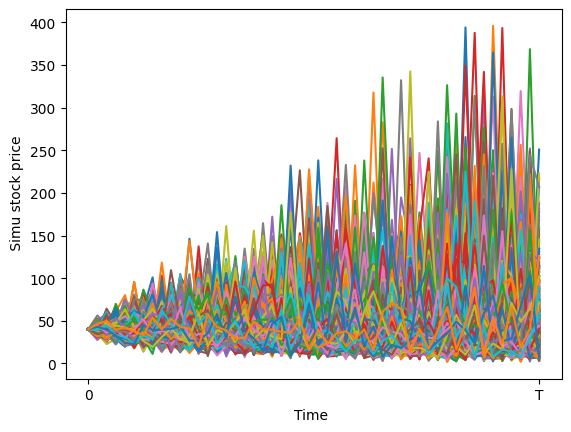

In [ ]:
# Transpose the temValue matrix to have time steps in the rows
temValue_T = temValue.T

# Plot the temValue values
plt.plot(temValue_T)
plt.xlabel('Time ')
plt.ylabel(' Simu stock price')

T_label = len(temValue_T) - 1
plt.xticks([0, T_label], [0, 'T'])

plt.show()


In [ ]:
# save paths

#file_path = '/content/drive/MyDrive/Colab Notebooks/price_path_50.pkl'
#with open(file_path, 'wb') as f:
#    pickle.dump(temValue, f)